# Project - Anomaly Detection

In [1]:
# imports
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn import metrics
from random import randint
from matplotlib import style
import env
import warnings
warnings.filterwarnings("ignore")
import itertools

# DBSCAN import
from sklearn.cluster import DBSCAN

# Scaler import
from sklearn.preprocessing import MinMaxScaler
# Pandas 
pd.set_option('display.max_row', None)

In [2]:
def check_columns(df, reports=False, graphs=False):
    """
    This function takes a pandas dataframe as input and returns
    a dataframe with information about each column in the dataframe. For
    each column, it returns the column name, the number of
    unique values in the column, the unique values themselves,
    the number of null values in the column, the proportion of null values,
    the data type of the column, and the range of the column if it is float or int. The resulting dataframe is sorted by the
    'Number of Unique Values' column in ascending order.

    Args:
    - df: pandas dataframe

    Returns:
    - pandas dataframe
    """
    print(f"Total rows: {df.shape[0]}")
    print(f"Total columns: {df.shape[1]}")
    if reports == True:
        describe = df.describe().round(2)
        pd.DataFrame(describe)
        print(describe)
    if graphs == True:
        df.hist(bins=20, figsize=(10, 10))
        plt.show()
    data = []
    # Loop through each column in the dataframe
    for column in df.columns:
        # Append the column name, number of unique values, unique values, number of null values, proportion of null values, and data type to the data list
        if df[column].dtype in ["float64", "int64"]:
            data.append(
                [
                    column,
                    df[column].dtype,
                    df[column].nunique(),
                    df[column].isna().sum(),
                    df[column].isna().mean().round(5),
                    df[column].unique(),
                    df[column].describe()[["min", "max", "mean"]].values,
                ]
            )
        else:
            data.append(
                [
                    column,
                    df[column].dtype,
                    df[column].nunique(),
                    df[column].isna().sum(),
                    df[column].isna().mean().round(5),
                    df[column].unique(),
                    None,
                ]
            )
    # Create a pandas dataframe from the data list, with column names 'Column Name', 'Number of Unique Values', 'Unique Values', 'Number of Null Values', 'Proportion of Null Values', 'dtype', and 'Range' (if column is float or int)
    # Sort the resulting dataframe by the 'Number of Unique Values' column in ascending order
    return pd.DataFrame(
        data,
        columns=[
            "col_name",
            "dtype",
            "num_unique",
            "num_null",
            "pct_null",
            "unique_values",
            "range (min, max, mean)",
        ],
    )

## Acquire

In [3]:
colnames = ['date','time','path', 'user_id', 'cohort_id', 'source_ip']
df = pd.read_csv("anonymized-curriculum-access.txt", 
                 sep="\s", 
                 header=None, 
                 names = colnames, 
                 usecols=[0, 1, 2, 3, 4, 5])
df.head()


,date,time,path,user_id,cohort_id,source_ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [4]:
#create SQL connection to logs
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
#SQL query
query = 'select * from cohorts'
df1 = pd.read_sql(query, url)

In [5]:
df1['name'].value_counts()

name
Arches                                    1
Staff                                     1
Ada                                       1
Andromeda                                 1
Betelgeuse                                1
Ceres                                     1
Bayes                                     1
Deimos                                    1
Europa                                    1
Fortuna                                   1
Curie                                     1
Apex                                      1
Ganymede                                  1
Hyperion                                  1
Darden                                    1
Io                                        1
Bash                                      1
Jupiter                                   1
Kalypso                                   1
Easley                                    1
Luna                                      1
Marco                                     1
Placeholder for students in

In [6]:
check_columns(df)

Total rows: 900223
Total columns: 6


,col_name,dtype,num_unique,num_null,pct_null,unique_values,"range (min, max, mean)"
0,date,object,1182,0,0.00000,"[2018-01-26, 2018-01-27, 2018-01-28, 2018-01-2...",None
1,time,object,73167,0,0.00000,"[09:55:03, 09:56:02, 09:56:05, 09:56:06, 09:56...",None
2,path,object,2313,1,0.00000,"[/, java-ii, java-ii/object-oriented-programmi...",None
3,user_id,int64,981,0,0.00000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.0, 981.0, 458.82570651938465]"
4,cohort_id,float64,47,52893,0.05876,"[8.0, 22.0, 21.0, 1.0, 16.0, 18.0, 19.0, nan, ...","[1.0, 139.0, 48.501049178006205]"
5,source_ip,object,5531,0,0.00000,"[97.105.19.61, 71.137.146.71, 209.205.123.242,...",None


In [7]:
# Set the index to datetime
# df.date = pd.to_datetime(df.date)
# df = df.set_index(df.date, drop=True)
# df = df.drop(columns='date')


In [8]:
# make another column for the endpoints
# df[['file_path', 'endpoints']] = 

df['endpoint'] = df['path'].str.split('/').str[-1]

In [9]:
df['startpoint'] = df['path'].str.split('/', n=1).str[0]

In [10]:
starter = df['startpoint'].unique().tolist()

In [11]:
starter

['',
 'java-ii',
 'slides',
 'javascript-i',
 'mkdocs',
 'git',
 'spring',
 'appendix',
 'index.html',
 'java-i',
 'html-css',
 'examples',
 'javascript',
 'mysql',
 'content',
 'jquery',
 'java',
 'javascript-ii',
 'teams',
 'java-iii',
 'prework',
 'asdf',
 'css',
 'single-page.html',
 'home',
 'assets',
 'forms',
 'css-i',
 'alumni-tech-survey-2018',
 'alumni-tech-survey-2018.html',
 'es6',
 'uploads',
 'introduction-to-java',
 'strings',
 'methods',
 'introduction',
 'elements',
 'file-io',
 'css-ii',
 'functions',
 'javascript-with-html',
 'conditionals',
 'bom-and-dom',
 'mvc',
 'students',
 'fundamentals',
 'setup',
 'group-by',
 'finish-the-adlister',
 'essential-methods',
 'ajax',
 'student',
 'hfdgafdja',
 'php',
 '.git',
 '.gitignore',
 'toc',
 'wp-admin',
 'wp-login',
 'registerUser',
 'search',
 'pre-work',
 'learn-to-code',
 'capstone-workbook',
 'jsp-and-jstl',
 'html',
 'handouts',
 'javascript-functions',
 'login',
 'quize',
 'cohorts',
 'PreWork',
 'app',
 'register.h

In [12]:
df.head()

,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,,
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,java-ii,java-ii
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,object-oriented-programming,java-ii
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,object_oriented_programming,slides
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,conditionals,javascript-i


In [13]:
df1.head()

,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,1,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
1,2,Badlands,#badlands,2014-06-04,2014-08-22,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
2,3,Carlsbad,#carlsbad,2014-09-04,2014-11-05,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
3,4,Denali,#denali,2014-10-20,2015-01-18,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
4,5,Everglades,#everglades,2014-11-18,2015-02-24,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1


In [14]:
df = df.fillna(value= -1)

In [15]:
check_columns(df)

Total rows: 900223
Total columns: 8


,col_name,dtype,num_unique,num_null,pct_null,unique_values,"range (min, max, mean)"
0,date,object,1182,0,0.0,"[2018-01-26, 2018-01-27, 2018-01-28, 2018-01-2...",None
1,time,object,73167,0,0.0,"[09:55:03, 09:56:02, 09:56:05, 09:56:06, 09:56...",None
2,path,object,2314,0,0.0,"[/, java-ii, java-ii/object-oriented-programmi...",None
3,user_id,int64,981,0,0.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.0, 981.0, 458.82570651938465]"
4,cohort_id,float64,48,0,0.0,"[8.0, 22.0, 21.0, 1.0, 16.0, 18.0, 19.0, -1.0,...","[-1.0, 139.0, 45.592593168581566]"
5,source_ip,object,5531,0,0.0,"[97.105.19.61, 71.137.146.71, 209.205.123.242,...",None
6,endpoint,object,1509,0,0.0,"[, java-ii, object-oriented-programming, objec...",None
7,startpoint,object,756,0,0.0,"[, java-ii, slides, javascript-i, mkdocs, git,...",None


In [16]:
df['cohort_id'] = df['cohort_id'].astype(int)

In [17]:
df0 = df.merge(df1, how='left', left_on= 'cohort_id', right_on='id')

In [18]:
df0.shape

(900223, 17)

In [19]:
df0.head()

,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8,97.105.19.61,,,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,java-ii,java-ii,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,object-oriented-programming,java-ii,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,object_oriented_programming,slides,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,conditionals,javascript-i,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


In [20]:
df0.date = pd.to_datetime(df0.date)
df0 = df0.set_index(df0.date, drop=True)
df0 = df0.drop(columns='date')

In [21]:
df0.head()

,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
date,,,,,,,,,,,,,,,,
2018-01-26,09:55:03,/,1,8,97.105.19.61,,,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,java-ii,java-ii,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,object-oriented-programming,java-ii,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,object_oriented_programming,slides,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,conditionals,javascript-i,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


In [22]:
check_columns(df0)

Total rows: 900223
Total columns: 16


,col_name,dtype,num_unique,num_null,pct_null,unique_values,"range (min, max, mean)"
0,time,object,73167,0,0.00000,"[09:55:03, 09:56:02, 09:56:05, 09:56:06, 09:56...",None
1,path,object,2314,0,0.00000,"[/, java-ii, java-ii/object-oriented-programmi...",None
2,user_id,int64,981,0,0.00000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.0, 981.0, 458.82570651938465]"
3,cohort_id,int64,48,0,0.00000,"[8, 22, 21, 1, 16, 18, 19, -1, 13, 14, 15, 7, ...","[-1.0, 139.0, 45.592593168581566]"
4,source_ip,object,5531,0,0.00000,"[97.105.19.61, 71.137.146.71, 209.205.123.242,...",None
5,endpoint,object,1509,0,0.00000,"[, java-ii, object-oriented-programming, objec...",None
6,startpoint,object,756,0,0.00000,"[, java-ii, slides, javascript-i, mkdocs, git,...",None
7,id,float64,47,52893,0.05876,"[8.0, 22.0, 21.0, 1.0, 16.0, 18.0, 19.0, nan, ...","[1.0, 139.0, 48.501049178006205]"
8,name,object,47,52893,0.05876,"[Hampton, Teddy, Sequoia, Arches, Niagara, Pin...",None
9,slack,object,46,52893,0.05876,"[#hampton, #teddy, #sequoia, #arches, #niagara...",None


## 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?


### It appears to be Javascript i mainly

In [23]:
df0.program_id.value_counts()

program_id
2.0    713365
3.0    103412
1.0     30548
4.0         5
Name: count, dtype: int64

In [24]:
# Program 1 dataframe
uno = df0[df0['program_id'] == 1]

<Axes: ylabel='path'>

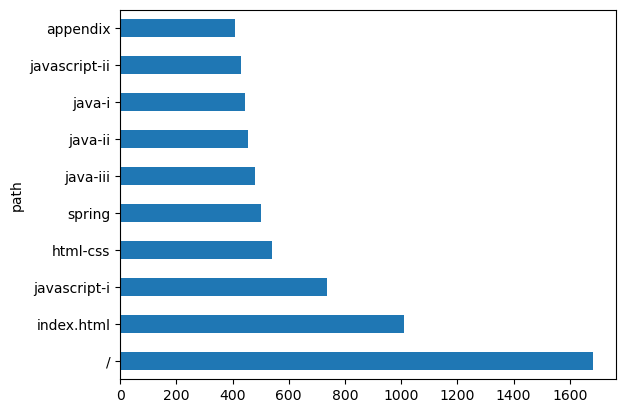

In [25]:
uno.path.value_counts().head(10).plot.barh()

javascript-i for cohorts with a program number of 1

In [26]:
# Program 2 dataframe
dos = df0[df0['program_id'] == 2]

<Axes: ylabel='path'>

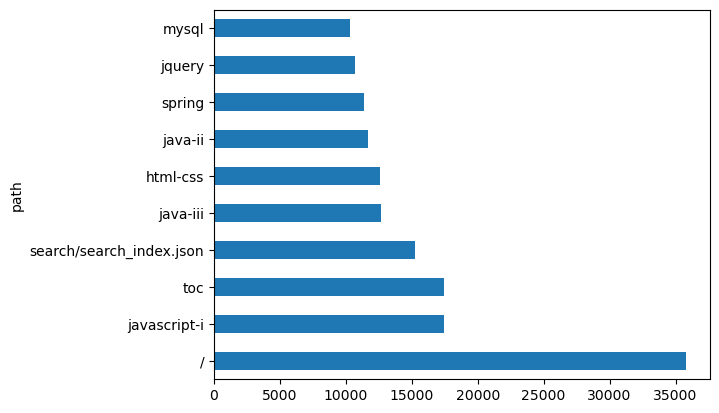

In [27]:
dos.path.value_counts().head(10).plot.barh()

spring for cohorts with a program number of 2

In [28]:
# Program 3 dataframe
tres = df0[df0['program_id'] == 3]

<Axes: ylabel='path'>

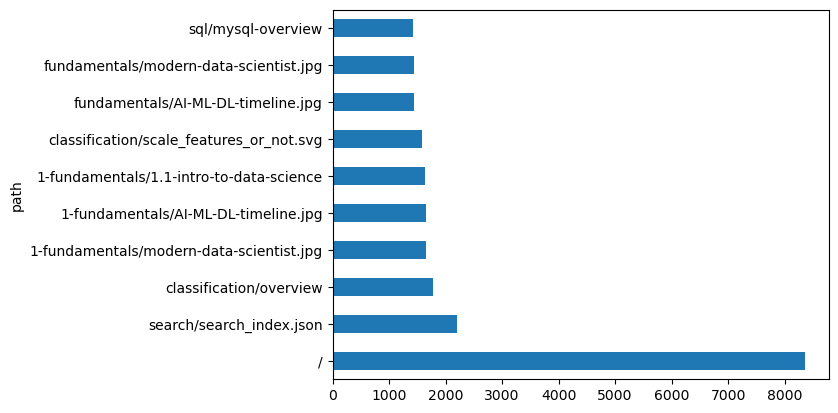

In [29]:
tres.path.value_counts().head(10).plot.barh()

appendix for cohorts with a program number 3

In [30]:
# Program 4 dataframe
quattro = df0[df0['program_id'] == 4]

<Axes: ylabel='path'>

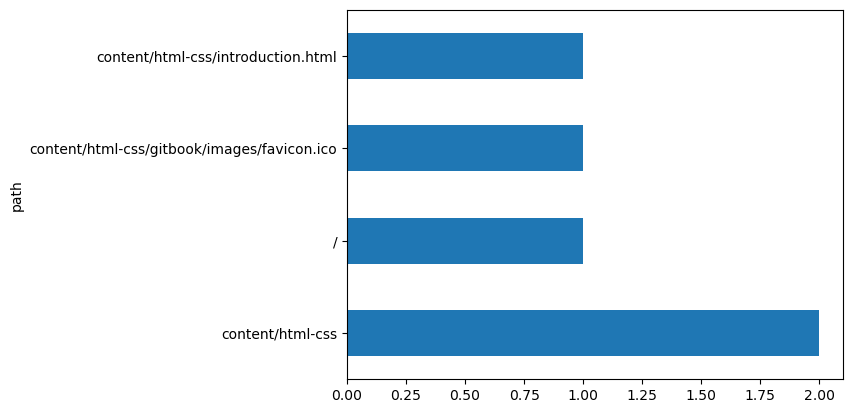

In [31]:
quattro.path.value_counts().head(10).plot.barh()

spring for cohorts with a program number of 4

## 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?


In [37]:
path_df = df0.path.value_counts().reset_index()
path_df.head()

,path,count
0,/,50313
1,search/search_index.json,19519
2,javascript-i,18983
3,toc,18297
4,java-iii,13733


In [38]:
path_df2 = df0.path.value_counts(normalize=True).reset_index()
path_df2.head(
)

,path,proportion
0,/,0.055889
1,search/search_index.json,0.021682
2,javascript-i,0.021087
3,toc,0.020325
4,java-iii,0.015255


In [39]:
path_df = pd.merge(path_df, path_df2, how='inner', on='path')
path_df.head()

,path,count,proportion
0,/,50313,0.055889
1,search/search_index.json,19519,0.021682
2,javascript-i,18983,0.021087
3,toc,18297,0.020325
4,java-iii,13733,0.015255


<Axes: ylabel='path'>

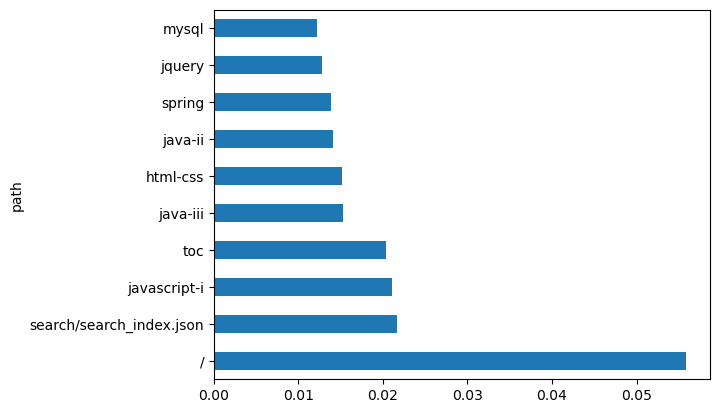

In [43]:
path_df.set_index('path').proportion.sort_values(ascending=False).head(10).plot.barh()

In [46]:
status_given_cohort = (df0.groupby('name').path.value_counts(normalize=True).rename('prob_path_giving_cohort').reset_index())
status_given_cohort.sort_values('prob_path_giving_cohort', ascending=False).head(15)

,name,path,prob_path_giving_cohort
4100,Everglades,/,1.000000
639,Apollo,content/html-css,0.400000
3600,Denali,prework/databases,0.250000
3601,Denali,mkdocs/search_index.json,0.250000
3602,Denali,/,0.250000
3599,Denali,prework/versioning/github,0.250000
642,Apollo,content/html-css/introduction.html,0.200000
641,Apollo,content/html-css/gitbook/images/favicon.ico,0.200000
640,Apollo,/,0.200000
985,Badlands,/,0.182796


### Apollo used html-css up to 40% compared to other cohorts

## 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?


In [ ]:
# index between start_date and end_date for each user and do a count
df2 = df0.reset_index()

In [ ]:
df2.head()

,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8,97.105.19.61,,,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,java-ii,java-ii,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,object-oriented-programming,java-ii,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,object_oriented_programming,slides,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,conditionals,javascript-i,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


In [ ]:
# so by user_id, count amount of times they are hit on log, 
# and see if it is between start_date, and end_date
within_date = (df2['date'] >= df2['start_date']) & (df2['date'] <= df2['end_date'])
df2[within_date].groupby('user_id').count()['date'].sort_values(ascending=True).head(10)

user_id
918    1
879    1
940    1
619    1
832    3
278    4
539    5
956    6
812    7
388    8
Name: date, dtype: int64

In [ ]:
slackers = df2[within_date].groupby('user_id').count()['date'].sort_values(ascending=True).head(10)
slackers.index


Index([918, 879, 940, 619, 832, 278, 539, 956, 812, 388], dtype='int64', name='user_id')

### These 10 users logged into the content rarely during their time at codeup.

In [ ]:
print(display(df2[df2['user_id'] == 918])) # This student appears to have dropped the course possibly since the access was on day one and then not again.


,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
847372,2021-03-15,16:59:56,/,918,138,71.221.46.112,,,138.0,Neptune,#neptune,2021-03-15,2021-09-03,2021-03-15 19:57:09,2021-03-15 19:57:09,None,2.0


None


In [ ]:
print(display(df2[df2['user_id']==879])) # Same as student above possibly


,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
799236,2021-01-26,12:21:18,/,879,135,136.50.50.187,,,135.0,Marco,#marco,2021-01-25,2021-07-19,2021-01-20 21:31:11,2021-01-20 21:31:11,None,2.0


None


In [ ]:
print(display(df2[df2['user_id'] == 940])) # possibly same fate as students above


,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
847404,2021-03-15,17:00:37,/,940,138,70.121.129.79,,,138.0,Neptune,#neptune,2021-03-15,2021-09-03,2021-03-15 19:57:09,2021-03-15 19:57:09,None,2.0


None


In [ ]:
print(display(df2[df2['user_id']==619])) # same as students above


,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
491139,2020-03-23,14:10:17,/,619,57,97.105.19.58,,,57.0,Ganymede,#ganymede,2020-03-23,2020-08-20,2020-03-23 17:52:16,2020-03-23 17:52:16,None,2.0


None


In [ ]:
print(display(df2[df2['user_id'] == 832])) # not completely sure about this student, accessed it halfway through course


,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
754195,2020-12-07,14:22:00,/,832,62,69.154.52.98,,,62.0,Jupiter,#jupiter,2020-09-21,2021-03-30,2020-09-21 18:06:27,2020-09-21 18:06:27,None,2.0
754204,2020-12-07,14:22:38,javascript-i,832,62,69.154.52.98,javascript-i,javascript-i,62.0,Jupiter,#jupiter,2020-09-21,2021-03-30,2020-09-21 18:06:27,2020-09-21 18:06:27,None,2.0
754206,2020-12-07,14:22:39,html-css,832,62,69.154.52.98,html-css,html-css,62.0,Jupiter,#jupiter,2020-09-21,2021-03-30,2020-09-21 18:06:27,2020-09-21 18:06:27,None,2.0


None


In [ ]:
print(display(df2[df2['user_id']==278])) # this student accessed the book more after they graduated than while in the course, and it appears they had
# access to both web dev and ds content


,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
131699,2018-09-27,13:57:44,/,278,24,97.105.19.58,,,24.0,Voyageurs,#voyageurs,2018-05-29,2018-10-11,2018-05-25 22:25:57,2018-05-25 22:25:57,None,2.0
131788,2018-09-27,14:47:37,java-ii/arrays,278,24,107.77.217.9,arrays,java-ii,24.0,Voyageurs,#voyageurs,2018-05-29,2018-10-11,2018-05-25 22:25:57,2018-05-25 22:25:57,None,2.0
131802,2018-09-27,14:58:48,java-ii/arrays,278,24,107.77.217.9,arrays,java-ii,24.0,Voyageurs,#voyageurs,2018-05-29,2018-10-11,2018-05-25 22:25:57,2018-05-25 22:25:57,None,2.0
131804,2018-09-27,14:59:07,java-ii/collections,278,24,107.77.217.9,collections,java-ii,24.0,Voyageurs,#voyageurs,2018-05-29,2018-10-11,2018-05-25 22:25:57,2018-05-25 22:25:57,None,2.0
141611,2018-10-16,18:55:42,/,278,24,67.11.175.66,,,24.0,Voyageurs,#voyageurs,2018-05-29,2018-10-11,2018-05-25 22:25:57,2018-05-25 22:25:57,None,2.0
141612,2018-10-16,18:56:02,javascript-ii,278,24,67.11.175.66,javascript-ii,javascript-ii,24.0,Voyageurs,#voyageurs,2018-05-29,2018-10-11,2018-05-25 22:25:57,2018-05-25 22:25:57,None,2.0
141613,2018-10-16,18:56:22,javascript-ii/es6,278,24,67.11.175.66,es6,javascript-ii,24.0,Voyageurs,#voyageurs,2018-05-29,2018-10-11,2018-05-25 22:25:57,2018-05-25 22:25:57,None,2.0
141616,2018-10-16,18:57:00,javascript-ii/map-filter-reduce,278,24,67.11.175.66,map-filter-reduce,javascript-ii,24.0,Voyageurs,#voyageurs,2018-05-29,2018-10-11,2018-05-25 22:25:57,2018-05-25 22:25:57,None,2.0
141617,2018-10-16,18:57:02,javascript-ii/promises,278,24,67.11.175.66,promises,javascript-ii,24.0,Voyageurs,#voyageurs,2018-05-29,2018-10-11,2018-05-25 22:25:57,2018-05-25 22:25:57,None,2.0
141618,2018-10-16,18:57:04,javascript-ii/ajax-api,278,24,67.11.175.66,ajax-api,javascript-ii,24.0,Voyageurs,#voyageurs,2018-05-29,2018-10-11,2018-05-25 22:25:57,2018-05-25 22:25:57,None,2.0


None


In [ ]:
print(display(df2[df2['user_id'] == 539])) # appears to be a staff member


,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
388308,2019-11-04,16:19:26,/,539,52,97.105.19.58,,,52.0,Europa,#europa,2019-11-04,2020-04-17,2019-11-04 18:27:07,2019-11-04 18:27:07,None,2.0
388309,2019-11-04,16:19:34,toc,539,52,97.105.19.58,toc,toc,52.0,Europa,#europa,2019-11-04,2020-04-17,2019-11-04 18:27:07,2019-11-04 18:27:07,None,2.0
388399,2019-11-04,16:54:02,html-css,539,52,97.105.19.58,html-css,html-css,52.0,Europa,#europa,2019-11-04,2020-04-17,2019-11-04 18:27:07,2019-11-04 18:27:07,None,2.0
388405,2019-11-04,16:54:38,html-css/introduction,539,52,97.105.19.58,introduction,html-css,52.0,Europa,#europa,2019-11-04,2020-04-17,2019-11-04 18:27:07,2019-11-04 18:27:07,None,2.0
388407,2019-11-04,16:54:45,html-css/elements,539,52,97.105.19.58,elements,html-css,52.0,Europa,#europa,2019-11-04,2020-04-17,2019-11-04 18:27:07,2019-11-04 18:27:07,None,2.0
388963,2019-11-05,11:04:37,spring,539,28,97.105.19.58,spring,spring,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0
388964,2019-11-05,11:05:16,html-css,539,28,97.105.19.58,html-css,html-css,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0
388965,2019-11-05,11:05:56,/,539,28,97.105.19.58,,,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0
390464,2019-11-06,15:29:09,html-css/forms,539,28,97.105.19.58,forms,html-css,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0
391381,2019-11-07,11:27:05,/,539,28,97.105.19.58,,,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0


None


In [ ]:
print(display(df2[df2['user_id']==956])) # student dropped course


,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
886731,2021-04-12,16:44:18,/,956,139,162.200.114.251,,,139.0,Oberon,#oberon,2021-04-12,2021-10-01,2021-04-12 18:07:21,2021-04-12 18:07:21,None,2.0
891690,2021-04-15,14:54:05,/,956,139,162.200.114.251,,,139.0,Oberon,#oberon,2021-04-12,2021-10-01,2021-04-12 18:07:21,2021-04-12 18:07:21,None,2.0
891694,2021-04-15,14:54:10,toc,956,139,162.200.114.251,toc,toc,139.0,Oberon,#oberon,2021-04-12,2021-10-01,2021-04-12 18:07:21,2021-04-12 18:07:21,None,2.0
891710,2021-04-15,14:55:05,javascript-i/introduction/operators,956,139,162.200.114.251,operators,javascript-i,139.0,Oberon,#oberon,2021-04-12,2021-10-01,2021-04-12 18:07:21,2021-04-12 18:07:21,None,2.0
891724,2021-04-15,14:56:04,javascript-i/introduction/primitive-types,956,139,162.200.114.251,primitive-types,javascript-i,139.0,Oberon,#oberon,2021-04-12,2021-10-01,2021-04-12 18:07:21,2021-04-12 18:07:21,None,2.0
891897,2021-04-15,15:32:22,javascript-i/introduction/operators,956,139,162.200.114.251,operators,javascript-i,139.0,Oberon,#oberon,2021-04-12,2021-10-01,2021-04-12 18:07:21,2021-04-12 18:07:21,None,2.0


None


In [ ]:
print(display(df2[df2['user_id'] == 812])) # accessed more after graduating


,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
724719,2020-11-08,01:45:34,html-css/css-i/selectors-and-properties,812,58,24.243.49.105,selectors-and-properties,html-css,58.0,Hyperion,#hyperion,2020-05-26,2020-11-10,2020-05-26 19:22:44,2020-05-26 19:22:44,None,2.0
724720,2020-11-08,01:45:41,html-css/elements,812,58,24.243.49.105,elements,html-css,58.0,Hyperion,#hyperion,2020-05-26,2020-11-10,2020-05-26 19:22:44,2020-05-26 19:22:44,None,2.0
724721,2020-11-08,01:45:56,html-css/css-i/introduction,812,58,24.243.49.105,introduction,html-css,58.0,Hyperion,#hyperion,2020-05-26,2020-11-10,2020-05-26 19:22:44,2020-05-26 19:22:44,None,2.0
724722,2020-11-08,01:46:01,html-css/css-i,812,58,24.243.49.105,css-i,html-css,58.0,Hyperion,#hyperion,2020-05-26,2020-11-10,2020-05-26 19:22:44,2020-05-26 19:22:44,None,2.0
724723,2020-11-08,01:46:04,html-css/forms,812,58,24.243.49.105,forms,html-css,58.0,Hyperion,#hyperion,2020-05-26,2020-11-10,2020-05-26 19:22:44,2020-05-26 19:22:44,None,2.0
724724,2020-11-08,01:46:06,html-css/elements,812,58,24.243.49.105,elements,html-css,58.0,Hyperion,#hyperion,2020-05-26,2020-11-10,2020-05-26 19:22:44,2020-05-26 19:22:44,None,2.0
724725,2020-11-08,01:46:07,html-css,812,58,24.243.49.105,html-css,html-css,58.0,Hyperion,#hyperion,2020-05-26,2020-11-10,2020-05-26 19:22:44,2020-05-26 19:22:44,None,2.0
734648,2020-11-17,15:31:04,html-css/css-i/selectors-and-properties,812,58,24.243.49.105,selectors-and-properties,html-css,58.0,Hyperion,#hyperion,2020-05-26,2020-11-10,2020-05-26 19:22:44,2020-05-26 19:22:44,None,2.0
734649,2020-11-17,15:31:13,jquery,812,58,24.243.49.105,jquery,jquery,58.0,Hyperion,#hyperion,2020-05-26,2020-11-10,2020-05-26 19:22:44,2020-05-26 19:22:44,None,2.0
734650,2020-11-17,15:31:15,javascript-i,812,58,24.243.49.105,javascript-i,javascript-i,58.0,Hyperion,#hyperion,2020-05-26,2020-11-10,2020-05-26 19:22:44,2020-05-26 19:22:44,None,2.0


None


In [ ]:
print(display(df2[df2['user_id']==388])) # dropped course

,date,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
221780,2019-03-19,09:50:19,/,388,31,97.105.19.58,,,31.0,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,None,2.0
221782,2019-03-19,09:50:23,html-css,388,31,97.105.19.58,html-css,html-css,31.0,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,None,2.0
221784,2019-03-19,09:50:28,html-css/elements,388,31,97.105.19.58,elements,html-css,31.0,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,None,2.0
221827,2019-03-19,10:04:11,html-css/elements,388,31,97.105.19.58,elements,html-css,31.0,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,None,2.0
221841,2019-03-19,10:19:32,html-css/elements,388,31,97.105.19.58,elements,html-css,31.0,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,None,2.0
221951,2019-03-19,11:11:51,html-css/forms,388,31,97.105.19.58,forms,html-css,31.0,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,None,2.0
221952,2019-03-19,11:12:02,html-css/elements,388,31,97.105.19.58,elements,html-css,31.0,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,None,2.0
222154,2019-03-19,12:19:23,html-css/elements,388,31,97.105.19.58,elements,html-css,31.0,Andromeda,#andromeda,2019-03-18,2019-07-30,2019-03-18 20:35:06,2019-03-18 20:35:06,None,2.0


None


## 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?


## 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?


In [ ]:
df0.head()

,time,path,user_id,cohort_id,source_ip,endpoint,startpoint,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
date,,,,,,,,,,,,,,,,
2018-01-26,09:55:03,/,1,8,97.105.19.61,,,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,java-ii,java-ii,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,object-oriented-programming,java-ii,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,object_oriented_programming,slides,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,conditionals,javascript-i,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


## 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?


In [ ]:
# so by user_id, count amount of times they are hit on log, 
# and see if it is OUTSIDE of end_date
grad_access = (df2['date'] > df2['end_date'])
grads = df2[grad_access]

In [ ]:
uno2 = (df2['program_id'] == 1)
dos2= (df2['program_id'] == 2)
tres2= (df2['program_id'] == 3)
quattro2 = (df2['program_id'] == 4)

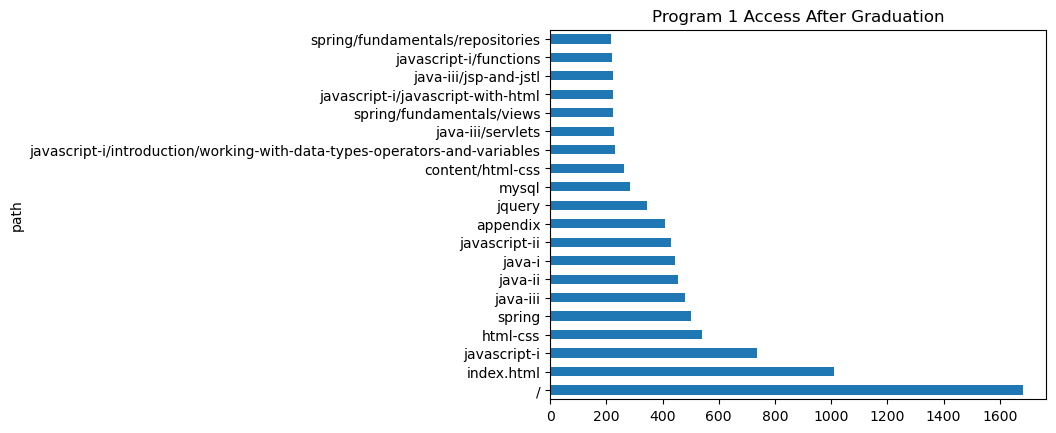

In [ ]:
df2[(uno2 & grad_access)]['path'].value_counts().sort_values(ascending=False).head(20).plot.barh()
plt.title('Program 1 Access After Graduation')
plt.show()

### It appears that javascript-i is still the main one other than the home page

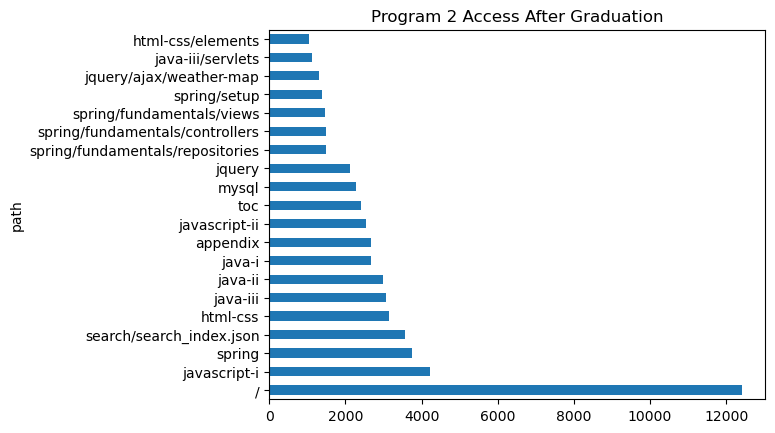

In [ ]:
df2[(dos2 & grad_access)]['path'].value_counts().sort_values(ascending=False).head(20).plot.barh()
plt.title('Program 2 Access After Graduation')
plt.show()

### Same here for the javascript-i

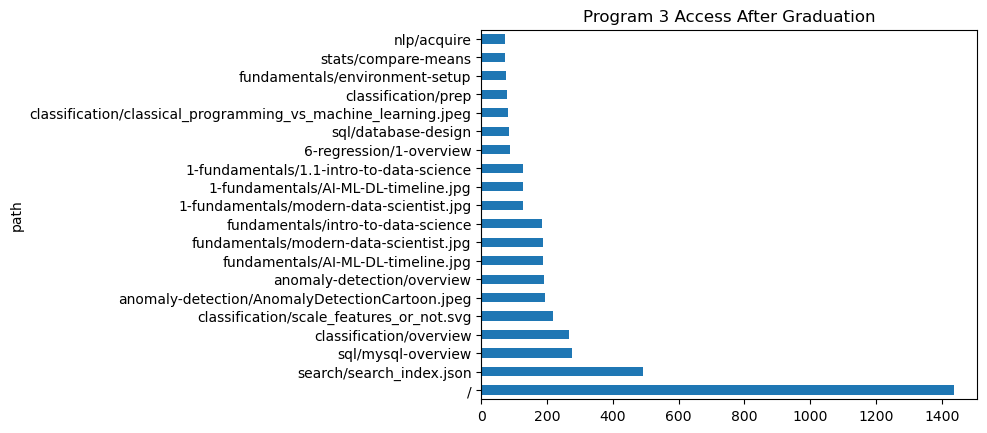

In [ ]:
df2[(tres2 & grad_access)]['path'].value_counts().sort_values(ascending=False).head(20).plot.barh()
plt.title('Program 3 Access After Graduation')
plt.show()

### For DS, its index_searches, probably because DS students are smarter and can find answers faster

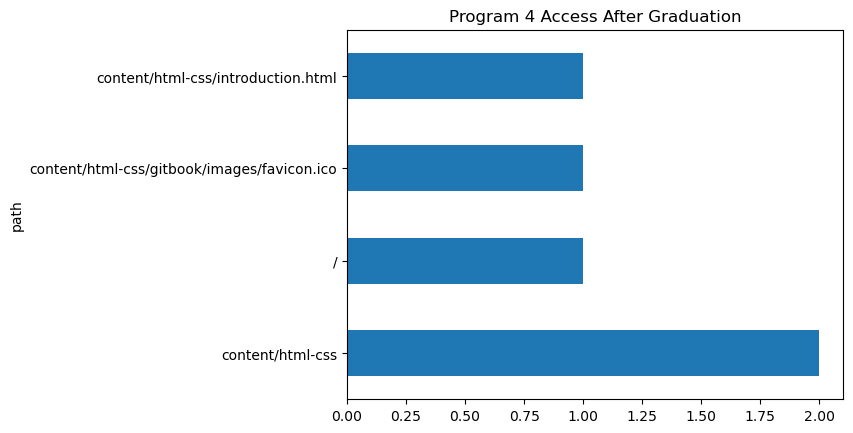

In [ ]:
df2[(quattro2 & grad_access)]['path'].value_counts().sort_values(ascending=False).head(20).plot.barh()
plt.title('Program 4 Access After Graduation')
plt.show()

### For this program, it appears that the html-css is the go to

## 7. Which lessons are least accessed?


In [48]:
# the code for the dataframe is up in question 2
path_df.tail()

,path,count,proportion
2309,12-distributed-ml/6.1-prepare-part-1,1,0.000001
2310,12-distributed-ml/6.4-prepare-part-4,1,0.000001
2311,4-python,1,0.000001
2312,4-python/overview,1,0.000001
2313,appendix/professional-development/post-intervi...,1,0.000001


### Theres quite a bit that seems to be least accessed equally here

8. Anything else I should be aware of?